# Toxic Comment Classification

In [1]:
'''
This script predicts toxic comments using a multi-label classification model. 
Several models were built and evaluated, the best models were used for predicting
the probability that a comment is considered toxic, i.e. belonging to any of 
6 categoires of toxic comments. 
'''
__author__ = "Mahsa Shokouhi"
__email__ = "mahsa_shokouhi@yahoo.com"

'\n'

# Import Packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (hamming_loss, accuracy_score, roc_auc_score,
                             classification_report, multilabel_confusion_matrix, 
                             fbeta_score, f1_score)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier

from skmultilearn.model_selection import IterativeStratification

pd.set_option('precision', 6)
%matplotlib inline

# Define Functions

In [3]:
 def stratified_split (X, Y, test_size):
    '''Stratified train-test split given specified test_size'''
    stratifier = IterativeStratification(n_splits=2, order=2, 
                                        sample_distribution_per_fold=[test_size, 
                                                                      1-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, Y))
    X_train, Y_train = X[train_indexes], Y.iloc[train_indexes, :]
    X_test, Y_test = X[test_indexes], Y.iloc[test_indexes, :]
    return X_train, X_test, Y_train, Y_test


def evaluate_model(model, X_train, Y_train, n_folds=3):
   '''Evaluate a model using stratified k-fold cross-validation.
   prints out mean accuracy, mean hamming loss, and mean f1-score across folds'''
   acc_train = []
   acc_test = []
   loss_train = []
   loss_test = []
   f1_train = []
   f1_test =[]

   k_fold = IterativeStratification(n_splits=n_folds, order=2)

   for tr_index, ts_index in k_fold.split(X_train, Y_train):
      model.fit(X_train[tr_index], Y_train.iloc[tr_index])
      pred_train = model.predict(X_train[tr_index])
      pred_test = model.predict(X_train[ts_index])
      acc_train.append(accuracy_score(Y_train.iloc[tr_index], pred_train))
      acc_test.append(accuracy_score(Y_train.iloc[ts_index], pred_test))
      loss_train.append(hamming_loss(Y_train.iloc[tr_index], pred_train))
      loss_test.append(hamming_loss(Y_train.iloc[ts_index], pred_test))
      f1_train.append(f1_score(Y_train.iloc[tr_index], pred_train, average='micro'))
      f1_test.append(f1_score(Y_train.iloc[ts_index], pred_test, average='micro'))

   print('Train set:\n')
   print(f'Mean accuracy score: {np.mean(acc_train)}, \n'
         f'Mean loss: {np.mean(loss_train)}, \n'
         f'Mean F1-score:{np.mean(f1_train)}')
   print('\nTest set:\n')
   print(f'Mean accuracy score: {np.mean(acc_test)}, \n'
         f'Mean loss: {np.mean(loss_test)}, \n'
         f'Mean F1-score:{np.mean(f1_test)}')

# Load Data

## Train set

In [4]:
train = pd.read_csv('../Data/train.csv')
print(train.shape)
train.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Define labels (toxic comments subgroups)
labels = train.columns[2:]
labels

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [6]:
# Check for missing values in each column
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
# Check all labels are either 0 or 1
[train[col].unique() for col in labels]

[array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1])]

## Test set

In [8]:
test = pd.read_csv('../Data/test.csv')
test_labels = pd.read_csv('../Data/test_labels.csv')

# Merge the two sets
test_labelled = pd.merge(test, test_labels, how='left', on='id')
print(test_labelled.shape)
test_labelled.head()

(153164, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [9]:
# Remove unlabelled rows from the test set (label=-1)
is_labelled = test_labelled.iloc[:, 2:] != -1
test_labelled = test_labelled[is_labelled.all(axis='columns')]
print(test_labelled.shape)

# Confirm the removal of unlabelled rows
[test_labelled[col].unique() for col in labels]

(63978, 8)


[array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1])]

# Exploratory Data Analysis

In [10]:
# Number of positive samples for each label (toxic types)
print(train.iloc[:, 2:].sum())

# Total number of rows with and without any type of toxic comments
n_nonToxic = train[train.iloc[:, 2:].sum(axis=1) == 0].shape[0]
n_toxic = train.shape[0] - n_nonToxic
print(f'There are {n_nonToxic} non-toxic and {n_toxic} toxic comments')

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
There are 143346 non-toxic and 16225 toxic comments


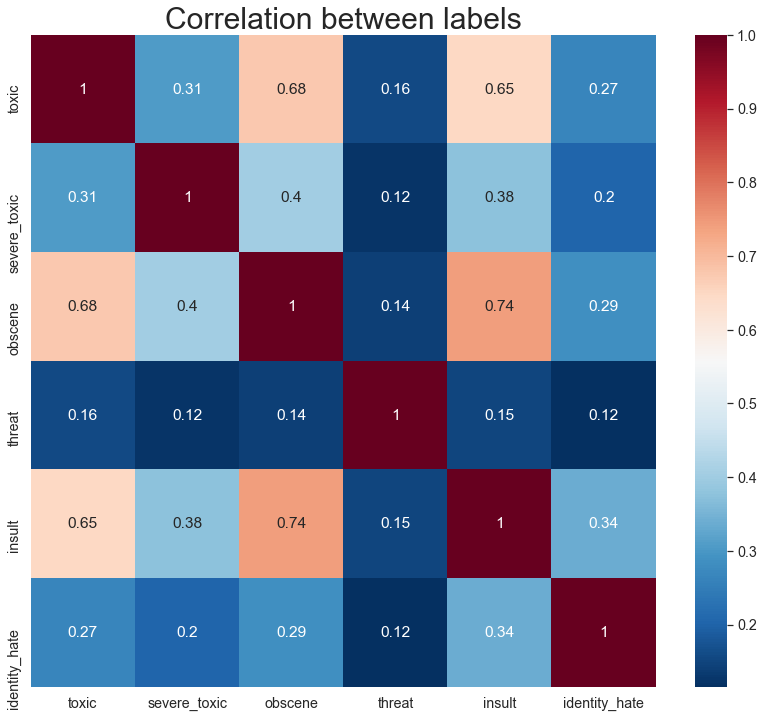

In [11]:
# Check correlation between labels
sns.set(font_scale=1.3)
plt.figure(figsize=(14, 12))
sns.heatmap(train.iloc[:, 2:].corr(), xticklabels=labels, yticklabels=labels, 
            cmap="RdBu_r", annot=True)
plt.title('Correlation between labels', fontsize=30)
plt.show()

## Compare percentage of labels in the train and test sets

In [12]:
# Train set
train_perentage = pd.DataFrame(
    train.iloc[:, 2:].value_counts(normalize=True, sort=False)).reset_index()
train_perentage.columns = list(labels) + ['train_percentage']
print(train_perentage.shape)
print('Lables percentages in the train set:')
print(train_perentage.head())

# Test set
test_perentage = pd.DataFrame(
    test_labelled.iloc[:, 2:].value_counts(normalize=True, sort=False)).reset_index()
test_perentage.columns = list(labels) + ['test_percentage']
print(test_perentage.shape)
print('Lables percentages in the train set:')
print(test_perentage.head())

# Merge the tow sets
labels_perentages = pd.merge(train_perentage, test_perentage, 
                             how='left', on=list(labels))
print(labels_perentages.shape)
labels_perentages.head()

(41, 7)
Lables percentages in the train set:
   toxic  severe_toxic  obscene  threat  insult  identity_hate  \
0      0             0        0       0       0              0   
1      0             0        0       0       0              1   
2      0             0        0       0       1              0   
3      0             0        0       0       1              1   
4      0             0        0       1       0              0   

   train_percentage  
0          0.898321  
1          0.000338  
2          0.001886  
3          0.000175  
4          0.000138  
(31, 7)
Lables percentages in the train set:
   toxic  severe_toxic  obscene  threat  insult  identity_hate  \
0      0             0        0       0       0              0   
1      0             0        0       0       0              1   
2      0             0        0       0       1              0   
3      0             0        0       0       1              1   
4      0             0        0       1       0    

,toxic,severe_toxic,obscene,threat,insult,identity_hate,train_percentage,test_percentage
0,0,0,0,0,0,0,0.898321,0.902420
1,0,0,0,0,0,1,0.000338,0.000219
2,0,0,0,0,1,0,0.001886,0.001000
3,0,0,0,0,1,1,0.000175,0.000063
4,0,0,0,1,0,0,0.000138,0.000078


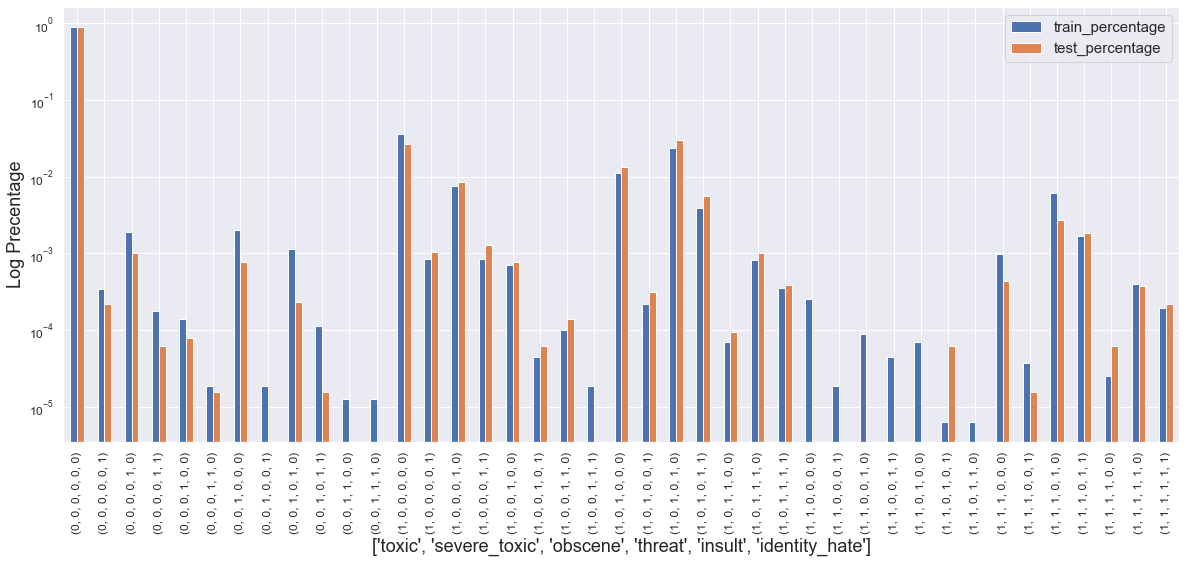

In [13]:
# Plot labels frequencies (percentage) for train and test sets
labels_perentages.set_index(list(labels), inplace=True)
labels_perentages.plot(kind='bar', logy=True, figsize=(20, 8), fontsize=12);
plt.legend(fontsize=15);
plt.xlabel(list(labels), fontsize=18);
plt.ylabel('Log Precentage', fontsize=18);

# Preprocessing

In [14]:
# Target variables: labels
Y = train.iloc[:, 2:]

# Features: Grid search for the max number of features with TfidfVectorizer
TVs = [TfidfVectorizer(max_features=5000*i, ngram_range=(1, 2), 
                       strip_accents='unicode', lowercase=True, 
                       stop_words='english') 
       for i in range(1, 11)]

scores = []
losses = []
for i in range(len(TVs)):
    X = TVs[i].fit_transform(train['comment_text'])
    # Train-test split
    X_train, X_test, Y_train, Y_test = stratified_split(X, Y, test_size=0.3)
    # Training
    classifier = ClassifierChain(LogisticRegression(max_iter=5000, 
                                                    random_state=100))
    classifier.fit(X_train, Y_train)
    predicted = classifier.predict(X_test)
    scores.append(accuracy_score(Y_test, predicted))
    losses.append(hamming_loss(Y_test, predicted))

print(f'scores:\n{scores}')
print(f'losses:\n{losses}')

scores:
[0.91876253342246, 0.9198696524064172, 0.9198278743315508, 0.9190967580213903, 0.9195772058823529, 0.9193683155080213, 0.9197860962566845, 0.9196189839572193, 0.9192638703208557, 0.919180314171123]
losses:
[0.019691399286987522, 0.019423323306595366, 0.019562583556149732, 0.019726214349376114, 0.019510360962566847, 0.019691399286987522, 0.019604361631016042, 0.01966006573083779, 0.019837622549019607, 0.019792362967914437]


In [15]:
# Text preprocessing with max_features=10000
tv = TVs[1]
X = tv.fit_transform(train['comment_text'])

# Train-test split
X_train, X_test, Y_train, Y_test = stratified_split(X, Y, test_size=0.3)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(111699, 10000) (111699, 6) (47872, 10000) (47872, 6)


# Baseline Model

In [16]:
# Define a dummy classifier for comparison
BL = DummyClassifier(strategy='stratified', random_state=100)
BL.fit(X_train, Y_train)
pred_train = BL.predict(X_train)
pred_test = BL.predict(X_test)

print('Classification report for test set')
print(classification_report(Y_test, pred_test, target_names=labels))
print('Classification report for train set')
print(classification_report(Y_train, pred_train, target_names=labels))

Classification report for test set
               precision    recall  f1-score   support

        toxic       0.09      0.09      0.09      4588
 severe_toxic       0.01      0.01      0.01       478
      obscene       0.05      0.05      0.05      2535
       threat       0.00      0.00      0.00       143
       insult       0.05      0.05      0.05      2363
identity_hate       0.01      0.01      0.01       425

    micro avg       0.06      0.06      0.06     10532
    macro avg       0.03      0.03      0.03     10532
 weighted avg       0.06      0.06      0.06     10532
  samples avg       0.01      0.01      0.01     10532

Classification report for train set
               precision    recall  f1-score   support

        toxic       0.10      0.10      0.10     10706
 severe_toxic       0.01      0.01      0.01      1117
      obscene       0.06      0.06      0.06      5914
       threat       0.00      0.00      0.00       335
       insult       0.05      0.05      0.05 

# Text classification
## Model selection: Spot check algorithms

In [17]:
%%time

# 1. Classifier Chains with DecisionTreeClassifier
cc_tree = ClassifierChain(DecisionTreeClassifier(random_state=100))
evaluate_model(cc_tree, X_train, Y_train, n_folds=3)

Train set:

Mean accuracy score: 0.9976051710400272, 
Mean loss: 0.0006274302664601593, 
Mean F1-score:0.9913860201067716

Test set:

Mean accuracy score: 0.8941888468115202, 
Mean loss: 0.026347594875513653, 
Mean F1-score:0.634614255722826
CPU times: user 14min 24s, sys: 17.9 s, total: 14min 41s
Wall time: 15min 33s


In [18]:
%%time

# 2. Classifier Chains with RandomForestClassifier
cc_rf= ClassifierChain(RandomForestClassifier(max_depth=60, max_features=250))
evaluate_model(cc_rf, X_train, Y_train, n_folds=3)

Train set:

Mean accuracy score: 0.9514095918495241, 
Mean loss: 0.011657072429774066, 
Mean F1-score:0.8136214701604129

Test set:

Mean accuracy score: 0.9171165364058765, 
Mean loss: 0.020200121158948006, 
Mean F1-score:0.6775953515195156
CPU times: user 24min 36s, sys: 30.5 s, total: 25min 7s
Wall time: 25min 57s


In [20]:
%%time

# 3. Classifier Chains with LogisticRegression
cc_lg = ClassifierChain(LogisticRegression(max_iter=1000))
evaluate_model(cc_lg, X_train, Y_train, n_folds=3)

Train set:

Mean accuracy score: 0.9259169732942998, 
Mean loss: 0.0177083053563595, 
Mean F1-score:0.7110986050620625

Test set:

Mean accuracy score: 0.9191845943114978, 
Mean loss: 0.019753981682915693, 
Mean F1-score:0.6732307422459566
CPU times: user 1min 34s, sys: 9.34 s, total: 1min 44s
Wall time: 1min 29s


In [21]:
%%time

# 4. Classifier Chains with LGBMClassifier
cc_lgbm = ClassifierChain(LGBMClassifier())
evaluate_model(cc_lg, X_train, Y_train, n_folds=3)

Train set:

Mean accuracy score: 0.9258543048729174, 
Mean loss: 0.017685923777294336, 
Mean F1-score:0.7114722414417155

Test set:

Mean accuracy score: 0.9188175364148291, 
Mean loss: 0.019840523788634337, 
Mean F1-score:0.6708251155426522
CPU times: user 1min 30s, sys: 4.19 s, total: 1min 35s
Wall time: 1min 17s


## Model Tuning and Evaluation

In [22]:
# Using labelled test set for models comparison
x_test = tv.transform(test_labelled['comment_text'])
y_test = test_labelled.iloc[:, 2:]
print(x_test.shape, y_test.shape)

(63978, 10000) (63978, 6)


In [23]:
# 1. LogisticRegression
lg = ClassifierChain(LogisticRegression(max_iter=1000, random_state=100))
# Train on the whole train data set and predict for the labelled test set
lg.fit(X, Y)  
predicted = lg.predict(x_test)

print(f'ROC AUC Score: {roc_auc_score(y_test, lg.predict_proba(x_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9636847796606922


Classification Report
               precision    recall  f1-score   support

        toxic       0.64      0.71      0.67      6090
 severe_toxic       0.38      0.27      0.32       367
      obscene       0.69      0.67      0.68      3691
       threat       0.39      0.21      0.27       211
       insult       0.59      0.60      0.59      3427
identity_hate       0.70      0.28      0.40       712

    micro avg       0.64      0.63      0.63     14498
    macro avg       0.57      0.46      0.49     14498
 weighted avg       0.63      0.63      0.63     14498
  samples avg       0.06      0.06      0.06     14498



In [24]:
# 2. LogisticRegression with balanced class weights
lg_balanced = ClassifierChain(LogisticRegression(max_iter=1000, 
                                                 random_state=100, 
                                                 class_weight='balanced'))
lg_balanced.fit(X, Y)
predicted = lg_balanced.predict(x_test)

print(f'ROC AUC Score: {roc_auc_score(y_test, lg_balanced.predict_proba(x_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9643241058652073


Classification Report
               precision    recall  f1-score   support

        toxic       0.41      0.91      0.56      6090
 severe_toxic       0.07      0.96      0.12       367
      obscene       0.29      0.94      0.44      3691
       threat       0.08      0.90      0.14       211
       insult       0.25      0.94      0.39      3427
identity_hate       0.06      0.95      0.12       712

    micro avg       0.24      0.93      0.38     14498
    macro avg       0.19      0.93      0.30     14498
 weighted avg       0.31      0.93      0.45     14498
  samples avg       0.05      0.09      0.06     14498



In [25]:
# 3. LGBMClassifier with default params
lgbm = ClassifierChain(LGBMClassifier(num_leaves=31, random_state=100))
lgbm.fit(X, Y)
predicted = lgbm.predict(x_test)

print(f'ROC AUC Score: {roc_auc_score(y_test, lgbm.predict_proba(x_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9125144179645769


Classification Report
               precision    recall  f1-score   support

        toxic       0.61      0.72      0.66      6090
 severe_toxic       0.33      0.27      0.30       367
      obscene       0.62      0.69      0.65      3691
       threat       0.13      0.36      0.20       211
       insult       0.52      0.62      0.57      3427
identity_hate       0.63      0.36      0.45       712

    micro avg       0.57      0.65      0.61     14498
    macro avg       0.47      0.50      0.47     14498
 weighted avg       0.58      0.65      0.61     14498
  samples avg       0.06      0.06      0.06     14498



In [26]:
# 4. LGBMClassifier v2: with regularization
lgbm2 = ClassifierChain(LGBMClassifier(num_leaves=31, reg_lambda=0.1, 
                                       random_state=100))
lgbm2.fit(X, Y)
predicted = lgbm2.predict(x_test)

print(f'ROC AUC Score: {roc_auc_score(y_test, lgbm2.predict_proba(x_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9497787959350626


Classification Report
               precision    recall  f1-score   support

        toxic       0.61      0.72      0.66      6090
 severe_toxic       0.32      0.26      0.29       367
      obscene       0.62      0.69      0.65      3691
       threat       0.36      0.34      0.35       211
       insult       0.52      0.62      0.57      3427
identity_hate       0.63      0.37      0.47       712

    micro avg       0.58      0.65      0.62     14498
    macro avg       0.51      0.50      0.50     14498
 weighted avg       0.58      0.65      0.61     14498
  samples avg       0.06      0.06      0.06     14498



In [27]:
# 5.  LGBMClassifier v3
lgbm3 = ClassifierChain(LGBMClassifier(num_leaves=40, reg_lambda=0.2, 
                                       random_state=100))
lgbm3.fit(X, Y)
predicted = lgbm3.predict(x_test)

print(f'ROC AUC Score: {roc_auc_score(y_test, lgbm3.predict_proba(x_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9486004171868928


Classification Report
               precision    recall  f1-score   support

        toxic       0.60      0.75      0.67      6090
 severe_toxic       0.34      0.26      0.30       367
      obscene       0.62      0.70      0.66      3691
       threat       0.41      0.30      0.35       211
       insult       0.53      0.63      0.58      3427
identity_hate       0.63      0.38      0.48       712

    micro avg       0.58      0.67      0.62     14498
    macro avg       0.52      0.50      0.50     14498
 weighted avg       0.58      0.67      0.62     14498
  samples avg       0.06      0.06      0.06     14498



In [28]:
# 6.  LGBMClassifier v4
lgbm4 = ClassifierChain(LGBMClassifier(num_leaves=60, reg_lambda=0.3, 
                                       random_state=100))
lgbm4.fit(X, Y)
predicted = lgbm4.predict(x_test)

print(f'ROC AUC Score: {roc_auc_score(y_test, lgbm4.predict_proba(x_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9598266919533217


Classification Report
               precision    recall  f1-score   support

        toxic       0.59      0.77      0.67      6090
 severe_toxic       0.34      0.27      0.30       367
      obscene       0.61      0.71      0.66      3691
       threat       0.38      0.29      0.33       211
       insult       0.54      0.63      0.58      3427
identity_hate       0.63      0.38      0.47       712

    micro avg       0.58      0.68      0.63     14498
    macro avg       0.51      0.51      0.50     14498
 weighted avg       0.58      0.68      0.62     14498
  samples avg       0.07      0.06      0.06     14498



# Kaggle Submission

In [29]:
test_x = tv.transform(test['comment_text'])
test_x.shape

(153164, 10000)

In [31]:
# 1. lg
lg_pred = lg.predict_proba(test_x)
lg_pred = pd.DataFrame(lg_pred, columns=labels)
lg_pred_df = pd.concat([test.id, lg_pred], axis=1)
lg_pred_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999080,0.252643,0.993132,0.058631,0.846011,0.400464
1,0000247867823ef7,0.009938,0.000053,0.002282,0.000248,0.003736,0.000622
2,00013b17ad220c46,0.012920,0.000039,0.001998,0.000152,0.003196,0.000646
3,00017563c3f7919a,0.004935,0.000067,0.002675,0.000227,0.002329,0.000270
4,00017695ad8997eb,0.039355,0.000043,0.002410,0.000244,0.003630,0.000449


In [32]:
# 2. lg_balanced
lg_balanced_pred = lg_balanced.predict_proba(test_x)
lg_balanced_pred = pd.DataFrame(lg_balanced_pred, columns=labels)
lg_balanced_pred_df = pd.concat([test.id, lg_balanced_pred], axis=1)
lg_balanced_pred_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999975,0.952884,0.999999,0.886003,0.998258,0.999028
1,0000247867823ef7,0.036103,0.000117,0.003835,0.001832,0.044379,0.003546
2,00013b17ad220c46,0.044768,0.000025,0.013203,0.000358,0.010908,0.009923
3,00017563c3f7919a,0.017847,0.000314,0.010372,0.001306,0.004802,0.001147
4,00017695ad8997eb,0.123038,0.000150,0.012722,0.002186,0.038796,0.002364


In [34]:
# 3. lgbm model with selected parameters
lgbm = ClassifierChain(LGBMClassifier(num_leaves=60, reg_lambda=0.3, 
                                      random_state=100))
lgbm.fit(X, Y)
lgbm_pred = lgbm.predict_proba(test_x)
lgbm_pred = pd.DataFrame(lgbm_pred, columns=labels)
lgbm_pred_df = pd.concat([test.id, lgbm_pred], axis=1)
lgbm_pred_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.996717,0.226351,0.983514,0.018750,0.937079,0.179152
1,0000247867823ef7,0.019485,0.000010,0.001207,0.000064,0.001376,0.000150
2,00013b17ad220c46,0.023512,0.000010,0.001309,0.000025,0.001376,0.000137
3,00017563c3f7919a,0.007282,0.000007,0.000929,0.000024,0.000839,0.000022
4,00017695ad8997eb,0.032834,0.000008,0.000877,0.000048,0.000865,0.000048


In [ ]:
# Save outputs to csv files for submission
lg_pred_df.round(6).to_csv('lg_submission.csv', index=False)
lg_balanced_pred_df.round(6).to_csv('lg_balanced_submission.csv', index=False)
lgbm_pred_df.round(6).to_csv('lgbm_submission.csv', index=False)